In [1]:
# Remove from public version
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from funcshape.networks import CurveReparametrizer
from funcshape.layers.sineseries import SineSeries
from funcshape.logging import Logger
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [3]:
def gaussian(t, p):
    out = np.zeros(t.shape)
    for i in range(1,p+1):
        zi = np.random.normal(1, 0.1)
        mean = (2*i-1)/(2*p)
        sigma = 1/(3*p)
        factor = 1/(2*(sigma**2))
        phi =  np.exp(-factor*(t-mean)**2)
        out += zi*phi

    return out

def warping(t):
    a = np.random.uniform(-3, 3)
    if a==0:
        gam = t
    else:
        gam = (np.exp(a*t)-1)/(np.exp(a)-1)

    return gam

class Function:
    def __init__(self, x, fx):
        self.x = x
        self.fx = fx
        coeffs = natural_cubic_spline_coeffs(self.x, self.fx)
        self.spline = NaturalCubicSpline(coeffs)

    def __call__(self, x):
        return self.spline.evaluate(x)

    def derivative(self, x, h=None):
        return self.spline.derivative(x, order=1)
    
    def compose(self, f):
        fx = f(self.x)
        y = self.spline.evaluate(fx).squeeze(-1)
        
        return Function(self.x, y)

### Display Figures Before Reparametrization

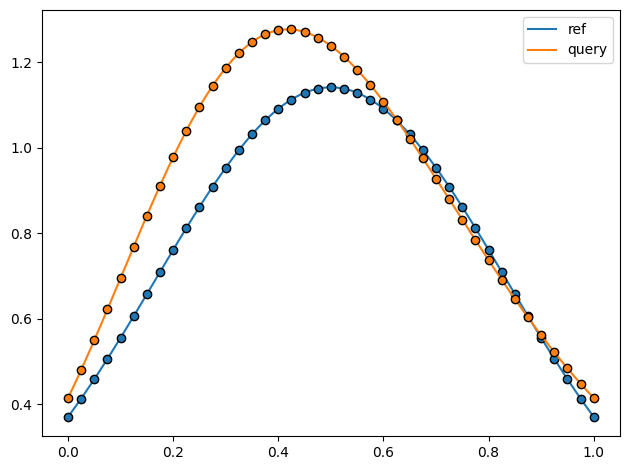

In [4]:
# Get function and a random warping function
use_true_gamma = False
time = torch.linspace(0,1,100)
t_ = np.linspace(0,1, len(time))
f1_ = gaussian(t_, np.random.randint(1,3))
gamma = warping(t_)

# Define function objects 
f1 = Function(time, torch.from_numpy(f1_).reshape(-1,1))
if not use_true_gamma:
    f2_ = gaussian(gamma, np.random.randint(1,3))
    f2 = Function(time, torch.from_numpy(f2_).reshape(-1,1))
else:
    diff = Function(time, torch.from_numpy(gamma).reshape(-1,1))
    f2 = f1.compose(diff)
    f2_ = f2(time).squeeze().numpy()

def plot_function(f, npoints=201, dotpoints=None, ax=None, **kwargs):
    x = torch.linspace(0, 1, npoints).squeeze()
    fx = f(x).squeeze()

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, fx, **kwargs)

    if dotpoints is not None:
        x = torch.linspace(0, 1, dotpoints).squeeze()
        fx = f(x).squeeze()
        ax.plot(
            x,
            fx,
            c=ax.lines[-1].get_color(),
            ls="none",
            marker="o",
            markeredgecolor="black",
        )

    return ax

fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
ax.legend()
plt.tight_layout()
plt.show()

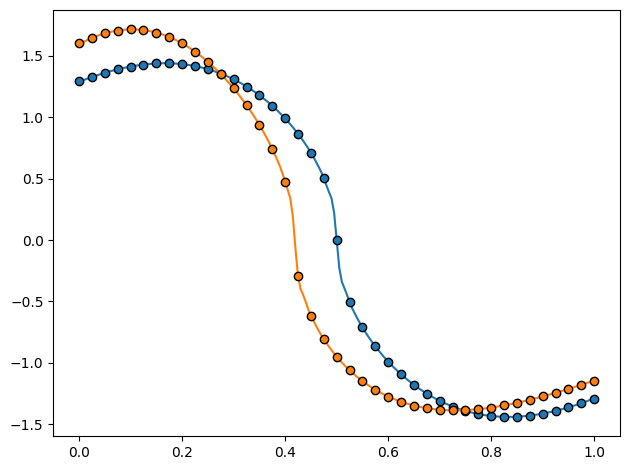

In [5]:
# Get SRSF maps
class SRSF:
    """SRSF transformation of functions"""

    def __init__(self, f : Function)-> None:
        self.function = f
        grad = self.function.derivative(self.function.x)
        self.x = self.function.x
        self.qx = grad / torch.sqrt(torch.abs(grad) + 1e-3)
        coeffs = natural_cubic_spline_coeffs(self.x, self.qx)
        self.spline = NaturalCubicSpline(coeffs)
        
    def __call__(self, gamma, h=None):
        gamma_x = (self.x[-1] - self.x[0]) * gamma + self.x[0]
        q_gamma = self.spline.evaluate(gamma_x)
        
        return q_gamma
    
    
q1, q2 = SRSF(f1), SRSF(f2)
fig, ax =plt.subplots()
plot_function(q1, dotpoints=41, ax=ax)
plot_function(q2, dotpoints=41, ax=ax)
plt.tight_layout()
plt.show()

In [6]:
from funcshape.loss import ShapeDistanceBase 

class FunctionDistance(ShapeDistanceBase):
    def __init__(self, q, r, k, h=1e-3, sample_type="linear"):
        self.sample_type = sample_type
        super().__init__(q, r, k, h=1e-3)
    def create_point_collection(self, k):
        if self.sample_type=="linear":
            return torch.linspace(0, 1, k).unsqueeze(-1)
        elif self.sample_type=="log":
            return torch.logspace(start=-10, end=0, steps=k).unsqueeze(-1)
            
    def get_determinant(self, network):
        return network.derivative(self.X, self.h)

    def loss_func(self, U, Y):
        r_phi = self.r(Y.squeeze()).squeeze()
        phi_dot = torch.sqrt(U + 1e-8).squeeze()
        error = ((self.Q.squeeze() - phi_dot * r_phi ) ** 2)
        l2_norm = torch.trapezoid(error, x=self.X.squeeze())
        
        return l2_norm

In [7]:
from funcshape.layers.layerbase import CurveLayer 
from abc import abstractmethod 
from math import pi, sqrt

class FunctionsBaseMetric(CurveLayer):
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.nvec = torch.arange(1, N + 1, dtype=torch.float)
        self.weights = torch.nn.Parameter(torch.randn(N, 1, requires_grad=True))
        self.weights = torch.nn.init.xavier_uniform_(self.weights)

    @abstractmethod
    def forward(self, x):
        pass 

    @abstractmethod
    def derivative(self, x, h=None):
        pass

    def project(self, eps=1e-6):
        with torch.no_grad():
            scale = (self.Ln*torch.abs(self.weights)).sum()
            if scale > 1.0 - eps:
                self.weights *= (1 - eps) / scale

    def to(self, device):
        self.nvec = self.nvec.to(device)
        return self

class L2Metric(FunctionsBaseMetric):
    def __init__(self, N):
        super().__init__(N)
        self.Ln = (pi/sqrt(2.0))*self.nvec
        self.project()

    def forward(self, x):
        term = torch.sin(pi * self.nvec * x)
        scale = (1/sqrt(2.0))
        return x + (term * scale) @ self.weights 

    def derivative(self, x, h=None):
        term = torch.cos(pi * self.nvec * x)
        scale = (pi*self.nvec)/sqrt(2.0)
        return 1.0 + (term * scale) @ self.weights
    
class PalaisMetric(FunctionsBaseMetric):
    def __init__(self, N):
        super().__init__(N)
        self.weights = torch.nn.Parameter(torch.randn(2*N, 1, requires_grad=True))
        self.weights = torch.nn.init.xavier_uniform_(self.weights)
        self.Ln = sqrt(2.0)
        self.project()

    def forward(self, x):
        t1 = (torch.sin(2.0 * pi * self.nvec * x)/(sqrt(2.0) * pi * self.nvec)) 
        t2 = ((torch.cos(2.0 * pi * self.nvec * x)-1.0)/(sqrt(2.0) * pi * self.nvec)) 
        return x + t1 @ self.weights[:self.N] + t2 @ self.weights[self.N:]

    def derivative(self, x, h=None):
        t1 = torch.cos(2.0 * pi * self.nvec * x)
        t2 = (torch.sin(2.0 * pi * self.nvec * x)) 

        return 1 + ((t1 @ self.weights[:self.N] - t2 @ self.weights[self.N:]) * sqrt(2.0)) 
    
class FisherRaoMetric(FunctionsBaseMetric):
    def __init__(self, N):
        super().__init__(N)
        self.Ln = 4.0
        self.project()

    def forward(self, x):
        term = (torch.sin(2.0 * pi * self.nvec * x)/(pi * self.nvec)) 
        return 4*x + term @ self.weights

    def derivative(self, x, h=None):
        term = torch.cos(2.0 * pi * self.nvec * x)

        return 4 + 2*(term@self.weights) 


In [8]:
N_BASIS = 10 
N_LAYERS = 10
LR = 1e-3
N_ITERS = 500
NUM_DOMAIN_POINTS = 100
N_RESTRATS = 30

# Define loss, optimizer and run reparametrization.
loss_func = FunctionDistance(q1, q2, k=NUM_DOMAIN_POINTS)

best_error_value = np.inf
for _ in range(N_RESTRATS):
    # Create reparametrization network
    basis = PalaisMetric(N_BASIS)
    RN = CurveReparametrizer([basis for _ in range(N_LAYERS)])

    # optimizer = optim.Adam(RN.parameters(), lr=LR)
    optimizer = optim.LBFGS(RN.parameters(), lr=LR, max_iter=N_ITERS, line_search_fn="strong_wolfe")
    error = reparametrize(RN, loss_func, optimizer, N_ITERS, Logger(0))

    if error[-1]<best_error_value:
        best_error = error
        best_error_value = best_error[-1]
        best_RN = RN
        print("Current best error : %2.4f"%best_error_value)

    if best_error_value<1e-2:
        break

# Get plot data to visualize diffeomorphism
best_RN.detach()
x = col_linspace(0, 1, NUM_DOMAIN_POINTS)
y = best_RN(x)

Current best error : 0.4133
Current best error : 0.0556
Current best error : 0.0322
Current best error : 0.0062


In [9]:
from apdist import SquareRootSlopeFramework as SRSF_

srsf = SRSF_(t_)
q_ref = srsf.to_srsf(f1_)
q_query = srsf.to_srsf(f2_)
optim_kwargs = {"optim":"DP", "grid_dim":10}
gamma_dp = srsf.get_gamma(q_ref, q_query, **optim_kwargs)


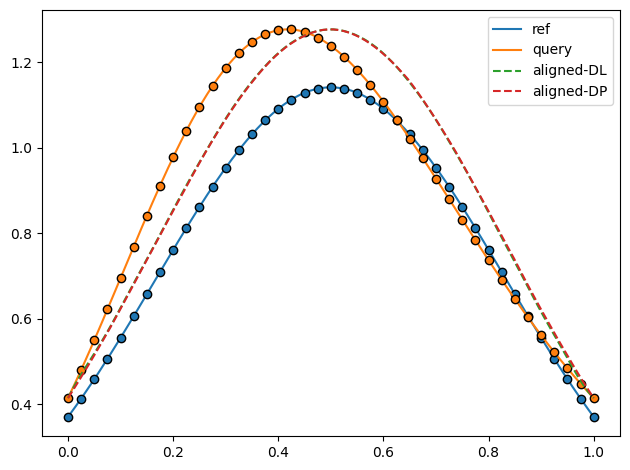

In [10]:
# Plot reparametrized curves and original
fig, ax =plt.subplots()
plot_function(f1, dotpoints=41, ax=ax, label="ref")
plot_function(f2, dotpoints=41, ax=ax, label="query")
f_query_gamma = srsf.warp_f_gamma(f2_, gamma_dp)
ax.plot(x, f2(y).squeeze(), ls='--', label="aligned-DL")
ax.plot(t_, f_query_gamma.squeeze(), ls='--', label="aligned-DP")
ax.legend()
plt.tight_layout()
plt.show()

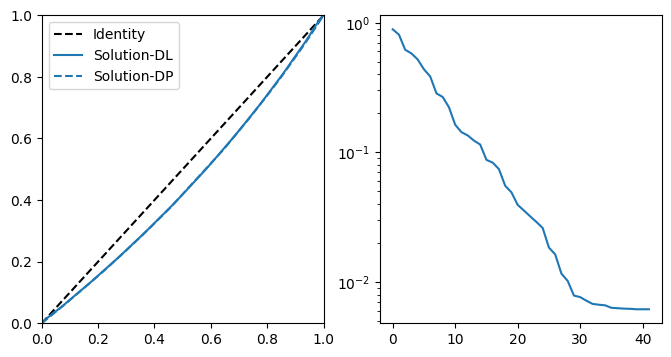

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(t_, t_, label="Identity", color="k", ls='--')
if use_true_gamma:
    ax1.plot(t_, gamma, label="Ground truth", color="k")
ax1.plot(x, y, label="Solution-DL")
ax1.plot(t_, gamma_dp, label="Solution-DP",
         ls = '--', color=ax1.lines[-1].get_color())
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.semilogy(best_error)
plt.show()